In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import colorcet as ccet
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
font = {'family' : 'sans-serif',
        'weight' : 'light'}
import time
from numba import jit

import pickle

rc('font', **font)  # pass in the font dict as kwargs
rc('animation', html='html5')
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib.animation import FFMpegWriter
metadata = dict(title='Final_Project_Boyle', artist='Matplotlib')
writer = FFMpegWriter(fps=120, metadata=metadata, bitrate=200000)

%matplotlib inline

Here I use the Leapfrog integration algorithm to ensure energy conservation of my particles. The leapfrog algorithm takes the form:
<br>
\begin{align}
\rm x_{i + 1} & = \rm x_i + v_i\Delta t + \frac{1}{2}a_i\Delta t^2 \\ 
\rm v_{i + 1} & = \rm v_i + \frac{1}{2}\left(a_i + a_{i + 1}\right)\Delta t
\end{align}
<br>

where 

<br>
\begin{align}
\rm a_i & = \rm \frac{-G \cdot m_n}{r_n^3}\cdot \vec{r}
\end{align}
<br>

and $\rm v_i$ and $\rm x_i$ are velocity and position. 

It is 2nd order integrator, though higher order forms exist. 

In [5]:
# Set the seed for reproducibility
np.random.seed(5)

In [1]:
def acceleration(obj, object_array):
    # The object array is constructed in the form of: [x, y, z, vx, vy, vz, r, m]
    # Where r is the radius of the particle. 
    G = 6.67408*(10**-11) # Gravitational constant
    
    dx = obj[0] - object_array[:,0]
    dy = obj[1] - object_array[:,1]
    dz = obj[2] - object_array[:,2]
    
    dr = np.array([dx, dy, dz])
    dist = np.linalg.norm(dr, axis = 0)
    
    a = -G*np.sum(object_array[:,7]*dr/dist**3, axis = 1)
    
    return a

def pos_check(object_array, max_dist):
    # Check how far away an object is
    good_dist = np.where(np.all(object_array[:,:3]**2 < max_dist**2, axis = 1))[0]
    
    object_array = object_array[good_dist]
    
    return object_array
    
def inelastic(object_array):
    # Radius of our particle is in obj[6]
    
    agg_ind_list = []
    full_ind_set = set(range(len(object_array)))
    
    for ii in range(len(object_array)):
        dist = np.linalg.norm(object_array[ii, :3] - object_array[:,:3], axis = 1)
        
        close = np.where((dist < object_array[ii, 6]) & (dist != 0))[0]
        
        if len(close) > 0:
            agg_ind = [ii]
            agg_ind.extend(close)
            agg_ind_list.append(agg_ind)
        
    if len(agg_ind_list) > 0:            
        agg_sorted = sorted(agg_ind_list, key = len, reverse = True)
        agg_done = []
        new_entries = []
        
        for agg in agg_sorted:
            current = [*agg]
            if not np.all(np.in1d(current, agg_done)):
                new_mass = np.sum(object_array[agg, 7]) #new mass
                new_rad = np.sum(object_array[agg, 6]**3)**(1/3) #new radius
                new_pos = list(np.sum(object_array[agg, :3] * object_array[agg, 7].reshape(len(agg), 1), axis = 0)/np.sum(object_array[agg, 7])) #new position
                
                new_vel = list(np.sum(object_array[agg, 3:6] * object_array[agg, 7].reshape(len(agg), 1), axis = 0)/(np.sum(object_array[agg, 7]))) #new velocity
                new_entry = np.array([*new_pos, *new_vel, new_rad, new_mass])
                new_entries.append(new_entry)
                agg_done.extend(agg)
                
        new_ind_list = list(full_ind_set - set(agg_done))
        new_array = np.vstack([object_array[new_ind_list], new_entries])
        
        return new_array
    
    else:
        return object_array

def leapfrog(object_arr, del_t):
    
#     object_arr = pos_check(object_arr, 100000)
    
    object_array = inelastic(object_arr)
    
    for obj in range(len(object_array)):
        obj_list = list(object_array)
        obj_i = obj_list.pop(obj)
        obj_arr = np.array(obj_list)
        
        a_1 = acceleration(obj_i, obj_arr)
        
        obj_i[:3] += obj_i[3:6]*del_t + 0.5*a_1*del_t**2
        
        a_2 = acceleration(obj_i, obj_arr)
        
        obj_i[3:6] += 0.5*(a_1 + a_2)*del_t
        
        object_array[obj] = obj_i
        
    return object_array

In [7]:
# Produce uniform sphere with 1000 points
max_n = 1000
radius = 250
n_points = 0
ang_rot = True
x_list = []
y_list = []
z_list = []
m_list = []
r_list = []
init_vx = np.zeros(max_n)
init_vy = np.zeros(max_n)
init_vz = np.zeros(max_n)
while n_points < max_n:
    rand_x = np.random.randint(-radius, radius)
    rand_y = np.random.randint(-radius, radius)
    rand_z = np.random.randint(-radius, radius)
    rand_m = np.random.randint(1, high = 5)
    rand_r = 1 + np.random.rand()
    dist = np.linalg.norm([rand_x, rand_y, rand_z])
    if dist > radius:
        continue
    else:
        x_list.append(rand_x)
        y_list.append(rand_y)
        z_list.append(rand_z)
        m_list.append(rand_m)
        r_list.append(rand_r)
        n_points += 1    
        
xyzm_array = np.transpose(np.vstack([x_list, y_list, z_list, init_vx, init_vy, init_vz, r_list, m_list]))

if ang_rot: 
    com = np.sum(xyzm_array[:,:3].transpose()*xyzm_array[:,7], axis = 1)/np.sum(xyzm_array[:,7])
    for obj in range(len(xyzm_array)):
        obj_list = list(xyzm_array)
        obj_i = obj_list.pop(obj)
        obj_arr = np.array(obj_list)
        
        a_1 = acceleration(obj_i, obj_arr)
        
        force = np.linalg.norm(a_1*obj_i[7])
        mu = np.sum(1/(1/xyzm_array[:,7]))
        r_cm = np.linalg.norm(com - xyzm_array[3,:3])
        
        tz = np.arctan2(obj_i[0], obj_i[1])
        tx = np.arctan2(obj_i[2], obj_i[1])
        
        cz = np.cos(-tz)
        sz = np.sin(-tz)
        cx = np.cos(-tx)
        sx = np.sin(-tx)
        
        rz = np.array([[cz, -sz, 0], [sz, cz, 0], [0, 0, 1]])
        rx = np.array([[1, 0, 0], [0, cx, -sx], [0, sx, cx]])
        
        v = np.array([np.sqrt(force*r_cm/mu), 0, 0])
        
        # Rotate v into particle
        v = rz@v
        v = rx@v
        
        xyzm_array[obj, 3] = v[0]
        xyzm_array[obj, 4] = v[1]
        xyzm_array[obj, 5] = v[2]

In [67]:
# Try to set up fading trails of each object
trail_x = []
trail_y = []
trail_z = []
trail_vx = []
trail_vy = []
trail_vz = []
trail_m = []
trail_r = []

t1 = time.time()

frames = 6000

for iteration in range(frames):
    
    xyzm_array = leapfrog(xyzm_array, 2**12)

    trail_x.append([*xyzm_array[:,0]])
    trail_y.append([*xyzm_array[:,1]])
    trail_z.append([*xyzm_array[:,2]])
    trail_vx.append([*xyzm_array[:,3]])
    trail_vy.append([*xyzm_array[:,4]])
    trail_vz.append([*xyzm_array[:,5]])
    trail_r.append([*xyzm_array[:,6]])
    trail_m.append([*xyzm_array[:,7]])
    
    t2 = time.time()
    
    print('Frame {0} done in {1:.2f} seconds, array length: {2}.'.format(iteration + 1, t2 - t1, len(xyzm_array)), end = '\r')

In [18]:
# trail_x, trail_y, trail_z, trail_m
com = np.sum(np.array([trail_x[-1], trail_y[-1], trail_z[-1]])*np.array(trail_m[-1]), axis = 1)/np.sum(np.array(trail_m[-1]))
com

array([ -465.71443016,  1404.57680483,   744.52356769])

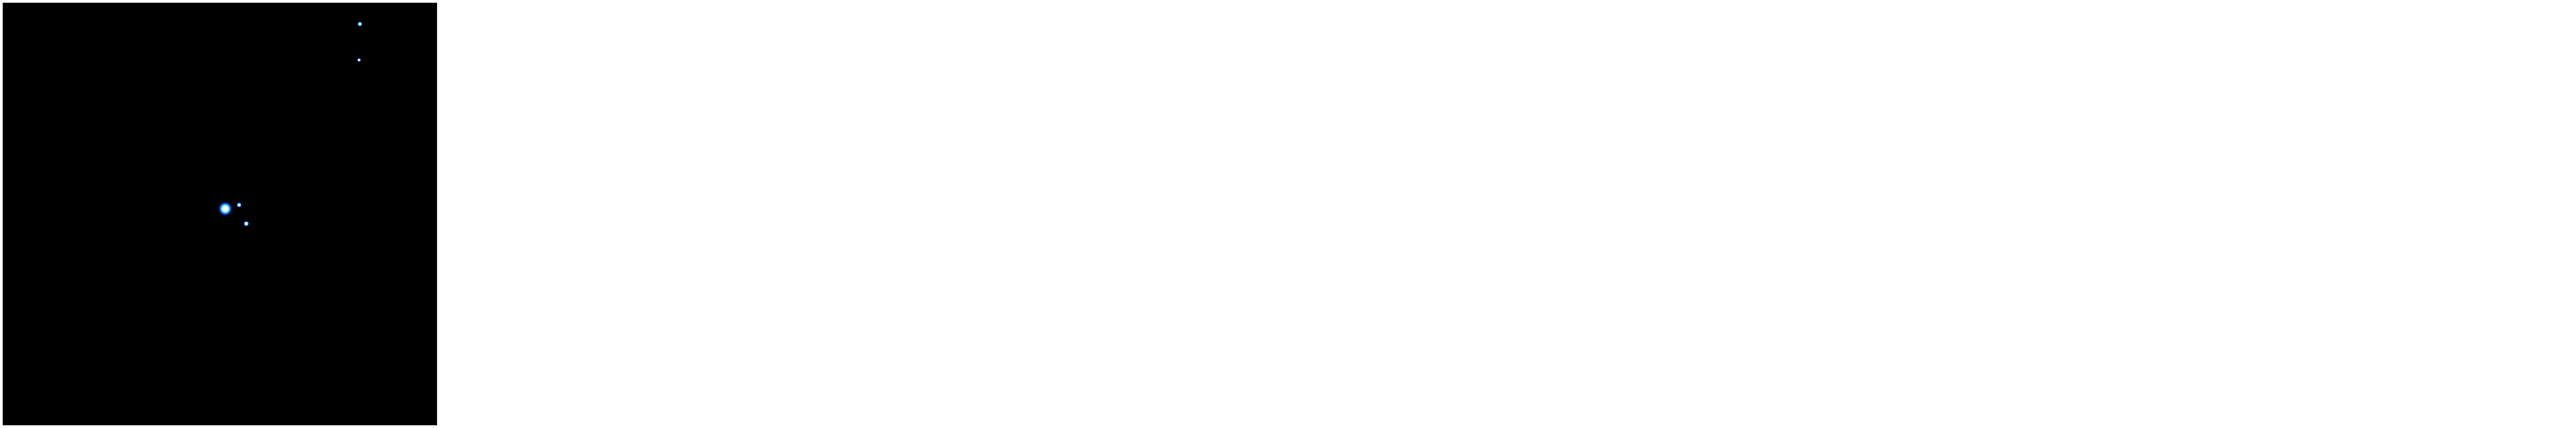

In [75]:
plt.clf()
plt.close('all')

# test_dict = pickle.load(open('p_1500_f_4000_dist_on_test.dat', 'rb'))

# trail_x = test_dict['x']
# trail_y = test_dict['y']
# trail_z = test_dict['z']
# trail_r = test_dict['r']
# trail_m = test_dict['m']

fig, ax = plt.subplots(figsize = (20, 20), subplot_kw = {'projection':'3d'})
ind = 4500
limit = 0.6*radius
com = np.sum(np.array([trail_x[ind], trail_y[ind], trail_z[ind]])*np.array(trail_m[ind]), axis = 1)/np.sum(np.array(trail_m[ind]))

# max_c = np.max(trail_m[-1])

# ax.set_facecolor('k')
# fig.set_frameon(False)

# colors = ['midnightblue', 'darkblue', 'blue', 'royalblue', 'dodgerblue', 'deepskyblue', 'lightskyblue', 'cyan', 'white']

# alpha_test = np.linspace(5, 1, 9)
# ax._axis3don = False
# for alp, cll in zip(alpha_test, colors):
#     ax.scatter(trail_x[ind], trail_y[ind], trail_z[ind], 
#                c = cll, marker='o', s = np.array(trail_r[ind])*4.5*alp, 
#                depthshade=False, alpha = 1/alp)
    
# limits_x = [com[0] - limit, com[0] + limit]
# limits_y = [com[1] - limit, com[1] + limit]
# limits_z = [com[2] - limit, com[2] + limit]
# ax.set_xlim(limits_x)
# ax.set_ylim(limits_y)
# ax.set_zlim(limits_z)

t1 = time.time()

frame = 0
reframe = 0
frames = len(trail_x)
alpha_check = np.linspace(5, 1, 9)
colors = ['midnightblue', 'darkblue', 'blue', 'royalblue', 'dodgerblue', 'deepskyblue', 'lightskyblue', 'cyan', 'white']
with writer.saving(fig, "p_{0}_r_{1}_col_f_{2}_ang_rot_60fps_4.mp4".format(max_n, radius, frames), dpi = 100):
    for xx, yy, zz, rr, mm in zip(trail_x, trail_y, trail_z, trail_r, trail_m):
        
        ax.clear()
        ax.set_facecolor('k')
        ax._axis3don = False
        for alp, cll in zip(alpha_check, colors):
            ax.scatter(xx, yy, zz, c = cll,  
                       marker='o', s = np.array(rr)*17*alp, 
                       depthshade=False, alpha = 1/alp)
        
        com = np.sum(np.array([xx, yy, zz])*np.array(mm), axis = 1)/np.sum(np.array(mm))
        
        limits_x = [com[0] - limit, com[0] + limit]
        limits_y = [com[1] - limit, com[1] + limit]
        limits_z = [com[2] - limit, com[2] + limit]

        ax.set_xlim(limits_x)
        ax.set_ylim(limits_y)
        ax.set_zlim(limits_z)
        
        writer.grab_frame()
        
        t2 = time.time()
        frame += 1
    
        print('Frame {0} of {1} done in {2:.2f} seconds, array length: {3}.'.format(frame, frames, t2 - t1, len(xx)), end = '\r')
plt.show()

In [76]:
# Save lists for future use
dictionary = {'x': trail_x, 'y': trail_y, 'z': trail_z, 'vx': trail_vx, 'vy': trail_vy, 'vz': trail_vz, 'r': trail_r, 'm': trail_m}

dict_file_name = 'p_{0}_f_{1}_ang_rot.dat'.format(max_n, frames)

with open(dict_file_name, 'wb') as outfile:
        pickle.dump(dictionary, outfile, protocol=pickle.HIGHEST_PROTOCOL)

# test_dict = pickle.load(open('p_1500_f_4000_dist_on_test.dat', 'rb'))